In [1]:
from importlib import reload
import matplotlib.pyplot as plt
from math import nan
import numpy as np
import pandas as pd
import pickle as pkl
from tqdm import tqdm
from IPython import get_ipython

import myprofiler as mp
import cleantools as clnt

# Introducion #

This file is for exploration, cleaning, and saving of data.

In [2]:
def reporting(all_sheets):
    """This section takes a report of everything

    """
    print("Reporting each contracts sheet...")
    for name, df in tqdm(all_sheets.items()):
        mp.getReport(df, "_".join(name.split()))

Below are the basic variables defined to aid our process.

In [3]:
files = {
    "locations": "../data/locations_20200520_143742.xlsx",
    "persons": "../data/persons_20200520_143122.xlsx",
    "personMentions": "../data/person_mentions_20200520_143017.xlsx",
    "personRelationships": "../data/person_relationships_20200520_143219.xlsx",
    "professions": "../data/professions_20200520_143812.xlsx",
    "categories": "../data/profession_categories_20200520_143818.xlsx",
}
unrelated_colums = {
    "Financial Conditions": None,
    "personMentions": None,
    "persons": None,
    "personRelationships": None,
    "categories": None,
    "contracts": None,
    "Names": None,
    "Hosting Conditions": ["Type of Clothing"],
    "Locations": ["GeoNames ID"],
    "Events": [
        "End Date",
        "Duration - Years",
        "Duration - Months",
        "Duration - Days",
    ],
}
contracts_sheets = [
    "Contracts",
    "Person Mentions",
    "Hosting Conditions",
    "Financial Conditions",
    "Events",
]

Here is the report making and information extracting section.

In [ ]:
print("Extracting sheets from contracts...")
all_sheets = mp.readFromXlsx(
    "../data/contracts_20200520_142649.xlsx", contracts_sheets
)

print("Extracting Rest of the xlsx documents...")
for name, file in tqdm(files.items()):
    all_sheets[name] = mp.readFromXlsx(file)

print("Reporting all sheets...")
reporting(all_sheets)

# Deeper analysis #

First, after the process I saved the variables to a pickle for faster access, so we read that.

In [4]:
all_sheets = clnt.loadPickle("../data/pickles/all_sheets.pkl")

First, we take a look at the *Duration* data in the *Events* sheet. Since it is split to three sections, we turn it to one numeric value for easier processing.

In [ ]:
# Processing for better information
# Merging different duration data into one numeric column
events = all_sheets["Events"].copy()
events["Duration - Merged"] = (
    events["Duration - Years"] * 365
    + events["Duration - Months"] * 30
    + events["Duration - Days"]
)

Secondly, we explore the ages of apprentices, after cleaning up the string formatted entries.

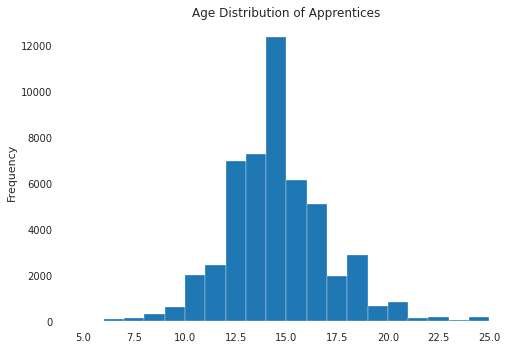

In [54]:
# Exploring apprentice age from person Mentions
temp = all_sheets["Person Mentions"].copy()
temp["Age - Standard Form"] = temp.loc[
    temp["Age"].apply(lambda x: clnt.isInt(x)), "Age"
]
temp["Professions - Standard Form"] = temp[
    "Professions - Standard Forms"
].copy()
temp = clnt.cleanColumns(
    temp, to_go=["Professions - Standard Forms", "Age"], eliminate_list=["Transcript"]
)
# clnt.savePickle(temp, "../data/pickles/clean_mentions.pkl")

temp = temp[temp["Tag"] == "grz:Apprentice"]
clnt.plotHist(temp["Age - Standard Form"], atype=float,
              title="Age Distribution of Apprentices", range=[5,25],
              bins=20)

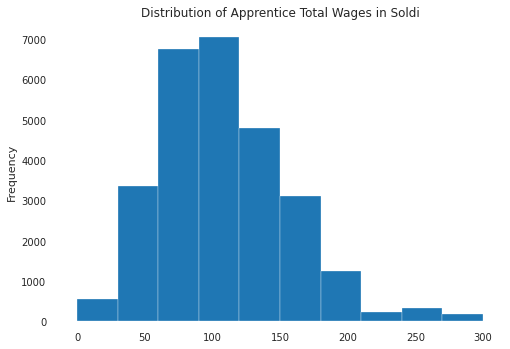

In [51]:
# Exploring the payment for apprenticeship
temp = all_sheets["Financial Conditions"].copy()
temp["Total - Standard Form"] = temp["Total Amount"] * temp[
    "Currency"
].apply(lambda x: clnt.currencyMap(x))
temp["Partial - Standard Form"] = temp["Partial Amount"] * temp[
    "Currency"
].apply(lambda x: clnt.currencyMap(x))
clean_money = temp[temp["Paid in Goods"] == False]
clean_money = clean_money[clean_money["Paid by"] == "grz:MasterPayer"]

# After some experiment, this seems to be the best rate for visualization
clnt.plotHist(
    clean_money.loc[
        clean_money["Total - Standard Form"] > 0,
        "Total - Standard Form"],
    range=[0, 300], title="Distribution of Apprentice Total Wages in Soldi"
)

# clnt.savePickle(clean_money, "../data/pickles/clean_Financial.pkl")

In [73]:
# Get the distribution of average ages depending the category of profession
mentions = clnt.loadPickle("../data/pickles/clean_mentions.pkl")
professions = all_sheets["professions"].copy()
temp = pd.merge(mentions[["Age - Standard Form", "Professions - Standard Form"]],
         professions[["Standard Form", "Category ID"]],
         left_on="Professions - Standard Form",
         right_on="Standard Form")
categories = all_sheets["categories"].copy()
temp = pd.merge(temp,
                categories[["Label", "Extended Label", "ID"]],
                left_on="Category ID", right_on="ID")[["Age - Standard Form",
                                                       "Professions - Standard Form",
                                                       "Label", "Extended Label"]]
temp["Age - Standard Form"] = pd.to_numeric(temp["Age - Standard Form"])

grouped_age = temp[["Age - Standard Form", "Label"]].groupby(["Label"]).agg(["mean", "count"])
grouped_age[(grouped_age[("Age - Standard Form", "mean")] > -1) &
            (grouped_age[("Age - Standard Form", "count")] > 20)].sort_values(("Age - Standard Form", "mean"), ascending=False)
# clnt.savePickle(grouped_age, "../data/pickles/age_with_prof_categories.pkl")

In [238]:
# Get the mapping of profession to where they come from, for only
# apprentices
temp = pd.merge(mentions[["Geo Origin - Standard Form", "Professions - Standard Form"]],
         professions[["Standard Form", "Category ID"]],
         left_on="Professions - Standard Form",
         right_on="Standard Form")
temp = pd.merge(temp,
                categories[["Label", "ID"]],
                left_on="Category ID", right_on="ID")[["Geo Origin - Standard Form",
                                                       "Label"]]


geo_counts = dict()
u = temp["Label"].unique()
for label in tqdm(u):
    geo_counts[label] = temp[
        temp["Label"] == label].groupby([
        "Geo Origin - Standard Form"
    ]).size().to_frame(name = 'count').reset_index()
# clnt.savePickle(geo_counts, "../data/pickles/profession_labels_with_province_counts_dict.pkl")

100%|██████████| 173/173 [00:01<00:00, 136.00it/s]
